# Parameter estimation for hydraulic model calibration and fault detection


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
This notebook implements sequential convex programming (SCP) to estimate roughness and local loss coefficients for hydraulic model calibration. The following steps should be performed to calibrate the hydraulic model:
1. Load network properties and operational data
2. Analyse preliminary model performance
3. Part 1: parameter estimation of pipe roughness (Hazen-Williams) coefficients **without** pipe grouping
4. Part 2: parameter estimation of pipe roughness (Hazen-Williams) coefficients **with** pipe grouping
5. Part 3: parameter estimation of pipe roughness (Hazen-Williams) coefficients **with** pipe grouping **and** valve loss coefficients

Each step should be followed by a brief discussion on your assumptions and the caibration results.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [ ]:
# run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !pip install cvxpy
  !apt-get install libsuitesparse-dev && pip install scikit-sparse

In [13]:
# load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from datetime import datetime, timedelta
import cvxpy as cp
import warnings
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Load network properties and operational data

Load functions created in previous assignments.

In [14]:
# load functions from src folder
if 'google.colab' in sys.modules:
    sys.path.append('/content/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *
else:
    sys.path.append('/home/bradw/workspace/CIVE_70019_70057/src/')
    from general_functions import *
    from hydraulic_functions import *

Load network .inp file and operational data from the module repository's data directory.

In [16]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'exning.inp'
data_name = 'exning_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx'] - 1 # matlab to python index offset
d_data = data['d']
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. Make a function for this.

In [17]:
#### DO NOT CHANGE THIS ####
# network plotting function
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info
    h0_df = wdn.h0_df

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=100, node_shape='s', node_color='black')

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(uG, pos, sensor_names, node_size=100, node_shape='o', node_color='red', edgecolors='white')

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='top')
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] - 1500)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 1000)

    # plot sensor vals
    if vals is not None:

        cmap = cm.get_cmap('RdYlGn_r')

        # plot residuals
        nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=100, node_shape='o', node_color=vals, cmap=cmap, edgecolors='white')

        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm)
        colorbar.set_label('Mean pressure residual [m]', fontsize=12)

    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

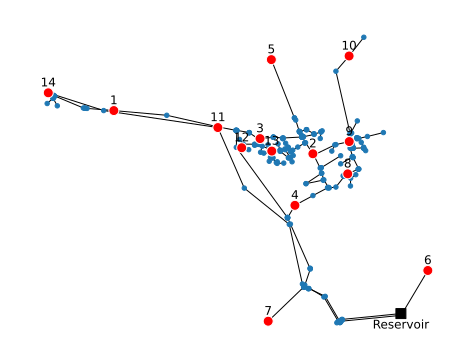

In [ ]:
plot_network(...)

### Preliminary model evaluation

Simulate initial (uncalibrated) network hydraulics over 8 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

<font color="blue">NB: this is done for you below. Provided the correct inputs, you do not need to replicate this function.

In [ ]:
#### DO NOT CHANGE THIS ####
# hydraulic solver function
def hydraulic_solver(inp_file, d_data, h0_data, C=None, demand=False):

    # load network from wntr
    inp_file = os.path.join(net_dir, net_name)
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.base_value = 1
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # replace demand data
    for idx, name in enumerate(junction_names):

        if any(val != 0 for val in d_data[idx, :]):
            node = wn.get_node(name)
            d_pat = d_data[idx, :]
            wn.add_pattern('d_'+name, d_pat)

            for (i, num) in enumerate(node.demand_timeseries_list):
                if i == 0:
                    node.demand_timeseries_list[i].base_value = 1
                    node.demand_timeseries_list[i].pattern_name = 'd_'+name
                else:
                    node.demand_timeseries_list[i].base_value = None
                    node.demand_timeseries_list[i].pattern_name = None

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():

            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial `C_0` values.

In [ ]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(...)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 8-day period. Visualise the results with, e.g., a boxplot of pressure residuals on the test dataset.

Text(0, 0.5, 'Pressure residual [m]')

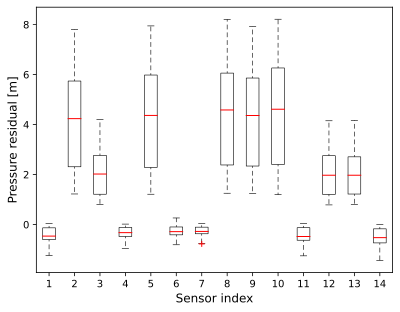

In [ ]:
# compute pressure residuals
residuals_0 = ...

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=12)
ax.set_ylabel('Pressure residual [m]', fontsize=12)

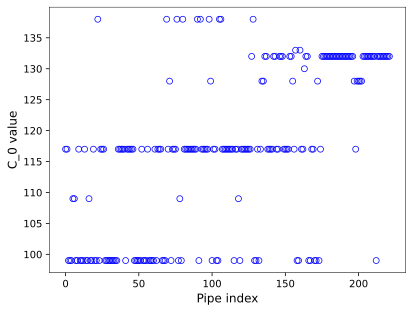

In [ ]:
# C_0 value scatter plot (pipes only)
pipe_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(...)
ax.set_xlabel('Pipe index', fontsize=12)
ax.set_ylabel('C_0 value', fontsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)

**<u>Question 1:</u>** Comment on the results of the preliminary model evaluation. In particular, justify the value of the observed pressure residuals at network sensors. Is the current hydraulic model of EXNING accurate according to hydraulic model calibration guidelines?

<font color="red">Enter response here...

### Part 1: parameter estimation without pipe grouping + valves fixed

Based on the initial comparison between simulated and measured pressures, we propose to calibrate the hydraulic model as an inverse parameter estimation problem. We also want to investigate the effect of pipe grouping on the solution of the calibration problem. In Part 1, we do NOT include pipe grouping (i.e. C values are free to vary) and we assume the status of valves is known with local (minor) loss coefficients fixed to C=0.2 (i.e. fully open).

We first need to split the operational data into train and test datasets.

In [ ]:
# tain data
nt_train = 24
data_train = {
    'd': ...,
    'h0': ...,
    'h_data': ...
}

# test data
data_test = {
    'd': ...,
    'h0': ...,
    'h_data': ...
}

The loss function is defined as the mean squared error (MSE) between simulated and measured pressures at sensor locations. Make the loss function below...

In [ ]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( ... - ... )**2 )

Compute MSE for `C_0` values and training data.

In [ ]:
h_0 = ...
mse_0 = loss_fun(...)
mse_0

**<u>Question 2:</u>** Briefly describe the problem of hydraulic model calibration and justify the definition of `loss_fun`.

<font color="red">Enter response here...

Solve the parameter estimation problem **without** pipe grouping.

The following function is needed for the sequential convex programming (SCP) method used in this coursework. <font color="blue">As with the `hydraulic_solver` function, we the following code in `linear_approx_calibration` is provided for you to use throughout this notebook.

In [ ]:
#### DO NOT CHANGE THIS ####
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx])
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation using the `cvxpy` modelling interface.

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0

# initialise values
theta_k = ...
q_k, h_k = hydraulic_solver(...)
a11_k, b1_k, b2_k = linear_approx_calibration(...)
objval_k = loss_fun(...)

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = ...
    h = ...
    theta = ...

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( ... )
    objective = cp.Minimize(...)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
          ...
        ]

    # trust region constraints
    constraints += [
        ...
    ]

    # variable bounds
    lower_bound_pipe = [...]
    constraints += ...
    upper_bound_pipe = [...]
    constraints += ...

    # valve minor loss coefficient constraints
    valve_constraints = [...]
    constraints += ...

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    [q_tilde, h_tilde] = hydraulic_solver(...)
    objval_tilde = loss_fun(...)

    predicted_decrease = ...
    actual_decrease = ...

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(...)
        Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
        delta_k = 1.1 * delta_k
        print(f"Iteration {k} ...! Update estimate and ... trust region size. \n")

    else:
        delta_k = 0.25 * delta_k
        print(f"Iteration {k} un...! Return to previous estimate and ... trust region size. \n")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

**<u>Question 3:</u>** Describe the nature/role of the different outputs of the SCP algorithm printed above (objvalk, Ki, Deltak) and explain their trends.

<font color="red">Enter response here...

In [ ]:
C_1 = theta_k

# compute train mse
mse_train_1 = loss_fun(...)
mse_train_1

Evaluate results on test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(...)

# compute test mse
mse_test_1 = loss_fun(...)
mse_test_1

Text(0, 0.5, 'Pressure residual [m]')

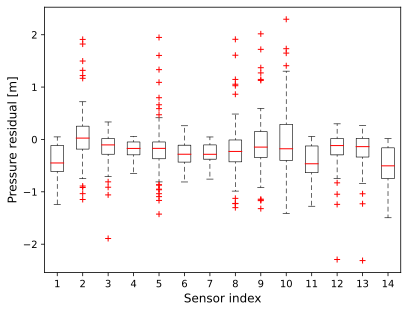

In [ ]:
# compute pressure residuals
residuals_1 = ...

# create a figure and axis for the box plots here
fig, ax = plt.subplots()
boxplot = ...

**<u>Question 4:</u>** Briefly comment on the improvement in model accuracy (before vs. after calibration). According to hydraulic model calibration guidelines (i.e. 95% of simulated heads within 2m of measurements), can the new model be considered "calibrated"?

<font color="red">Enter response here...

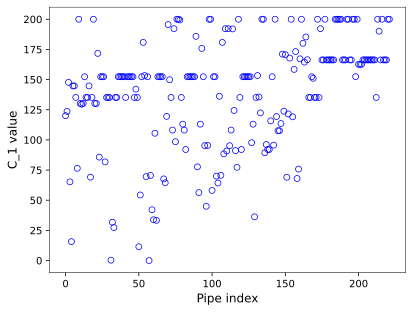

In [ ]:
# generate C_1 value scatter plot (pipes only)

**<u>Question 5:</u>** Comment on the results of the model calibration without pipe grouping. In particular, discuss the calibrated `c_1` values. Are these realistic?

<font color="red">Enter response here...

### Part 2: parameter estimation with pipe grouping + valves fixed

Load pipe grouping information.

In [ ]:
link_groups = data['G'][0] - 1 # matlab to python index offset
ng = link_groups.shape[0]
thetaG_lo = data['thetaG_min'][:, 0]
thetaG_up = data['thetaG_max'][:, 0]

Main SCP code **with** pipe grouping.

In [ ]:
# unload network training data
n_exp = link_df['n_exp']
d = data_train['d']
h_data = data_train['h_data']
h0 = data_train['h0'].reshape(-1, 1).T

# define problem parameters
Ki = np.inf
iter_max = 50
delta_k = 20
C_up_pipe = 200
C_lo_pipe = 0

# initialise values
theta_k = ...
q_k, h_k = hydraulic_solver(...)
a11_k, b1_k, b2_k = linear_approx_calibration(...)
objval_k = loss_fun(...)

### main scp code ###
for k in range(iter_max):

    # decision variables
    q = ...
    h = ...
    theta = ...
    thetaG = cp.Variable(ng)

    # objective function (defined using CVXPY functions)
    loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( ... )
    objective = cp.Minimize(...)

    # hydraulic feasibility constraints
    constraints = []
    for t in range(nt_train):
        # energy and mass constraints
        constraints += [
            ...,
            ...
        ]

    # trust region constraints
    constraints += [
       ...
    ]

    # pipe grouping constraints
    for j in range(ng):

        # equality constraints
        for idx in link_groups[j]:
            constraints += [
                ...
            ]

        # pipe grouping bounds
        constraints += [
            thetaG[j] >= ...,
            thetaG[j] <= ...
        ]

    # C bounds
    lower_bound_pipe = [...]
    constraints += ...
    upper_bound_pipe = [...]
    constraints += ...

    # valve minor loss coefficient constraints
    valve_constraints = ...
    constraints += ...

    # solve optimisation problem
    problem = cp.Problem(objective, constraints)
    cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

    # store optimal solution and compute actual and predicted decrease in objval
    theta_tilde = theta.value
    thetaG_tilde = thetaG.value
    q_tilde, h_tilde = hydraulic_solver(...)
    objval_tilde = loss_fun(...)

    predicted_decrease = ...
    actual_decrease = ...

    # evaluate latest SCP iteration
    if actual_decrease / predicted_decrease >= 0.1:
        objval_old = objval_k
        theta_k = theta_tilde
        thetaG_k = thetaG_tilde
        q_k = q_tilde
        h_k = h_tilde
        objval_k = objval_tilde
        a11_k, b1_k, b2_k = linear_approx_calibration(...)
        Ki = ...
        delta_k = 1.1 * delta_k
        print(f"...")

    else:
        delta_k = 0.25 * delta_k
        print(f"...")

    print(f"{k} {objval_k} {Ki} {delta_k} \n")

    if Ki <= 1e-3 or np.abs(objval_k) <= 1e-2 or delta_k <= 1e-1:
        break

In [ ]:
C_2 = ...

# compute train mse
mse_train_2 = loss_fun(...)
mse_train_2

3.729985060303179

Evaluate results on test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(...)

# compute test mse
mse_test_2 = loss_fun(...)
mse_test_2

3.5152320163936177

Text(0, 0.5, 'Pressure residual [m]')

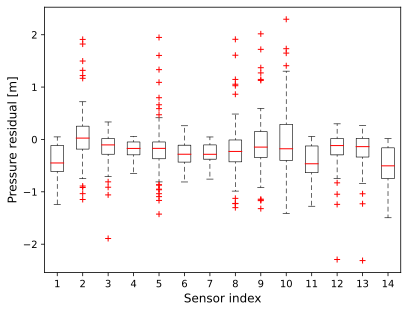

In [ ]:
# compute pressure residuals
residuals_2 = ...

# create a figure and axis for the box plots here
fig, ax = plt.subplots()
boxplot = ...

**<u>Question 6:</u>** Comment on the difference in model accuracy after calibration with ($C_2$) and without ($C1$) pipe grouping. According to hydraulic model calibration guidelines, can the model with $C_2$ parameters be considered "calibrated"?

<font color="red">Enter response here...

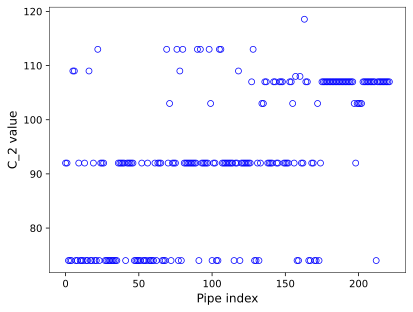

In [ ]:
# generate C_2 value scatter plot (pipes only)

**<u>Question 8:</u>** Comment on the values of the H-W coefficient estimates in $C_2$ compared to $C_1$. Explain the differences (if any).

<font color="red">Enter response here...

#### Identify sensors with largest residuals

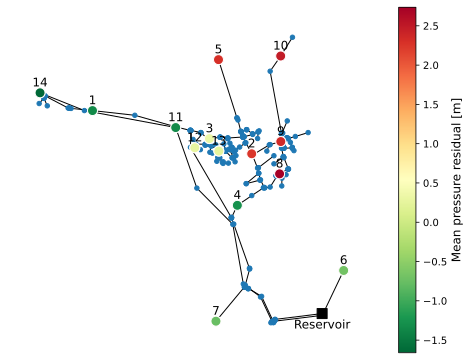

In [ ]:
# spatial residuals plot
mean_residuals_2 = np.mean(...)
plot_network(wdn, sensor_idx, vals=...) # call network plotting function

**<u>Question 9:</u>** Interpret the deviations observed between simulated and measured pressures by addressing the following questions:
* Are the values of the pressure residuals evenly distributed around 0?
* Does the hydraulic model over- or under-estimate pressure heads?
* What could the nature and location of the fault causing these residuals be?

<font color="red">Enter response here...

### Part 3: parameter estimation with pipe grouping + valve coefficients

The H-W coefficients in `C_2` (obtained by solving the parameter estimation problem with pipe grouping) result in larger residuals between measured and simulated pressures. Large, localised deviations between measured and simulated pressures can occur as the result of unknown changes in the network (or faults), such as unknowingly closed valves for instance. In particular, faults associated with an unknown valve status can be located by solving a model calibration problem where valve loss coefficients are free to vary.
In this part of the coursework, you are encouraged to propose and investigate an approach to solving the **single** fault localisation problem. You may follow the suggested steps below

Approach to solving the fault localisation problem:
1. Modify the CVXPY implementation in Part 2 to allow valve loss coefficient estimates to vary. Solve the resulting parameter estimation problem and interpret the optimal value of `C_3`.
2. Consider the expected values of valve loss coefficient estimates `C_3` in the single fault localisation problem. Modify the CVXPY implementation by including a regularisation term in the objective function to account for the nature of the single fault localisation problem. Interpret your results accordingly.
3. Compare the results of Part 3 with Part 2 and explain whether they contradict or corroborate your previous conclusions about the nature and location of the detected fault.

#### Part 3a: free valve coefficients

Load pipe grouping data.

In [9]:
# insert code here...

Main SCP code.

In [19]:
# insert code here...

In [ ]:
C_3a = ...

# compute train mse
mse_train_3a = loss_fun(...)
mse_train_3a

Evaluate results on test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(...)

# compute test mse
mse_test_3a = loss_fun(...)
mse_test_3a

Text(0, 0.5, 'Pressure residual [m]')

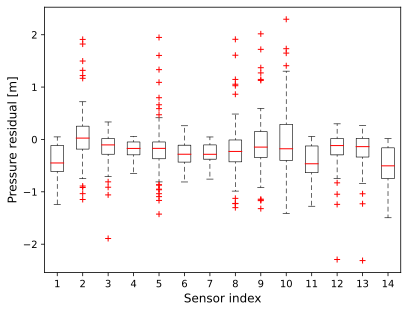

In [ ]:
# compute pressure residuals
residuals_3a = ...

# create a figure and axis for the box plots here
fig, ax = plt.subplots()
boxplot = ...

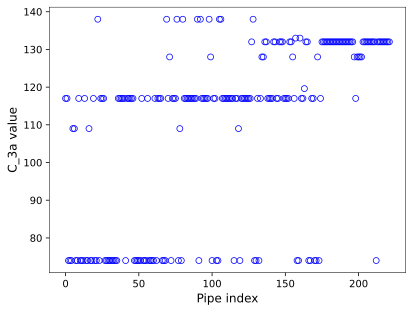

In [ ]:
# generate C_3a value scatter plot (pipes)

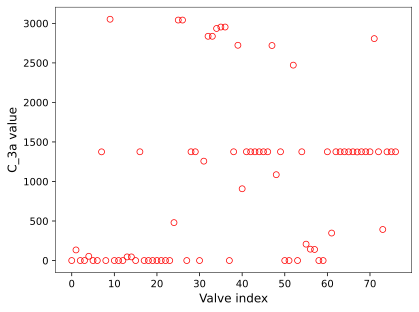

In [ ]:
# C_3a value scatter plot (valves)
valve_C = [...]
fig, ax = plt.subplots()
ax.scatter(...)

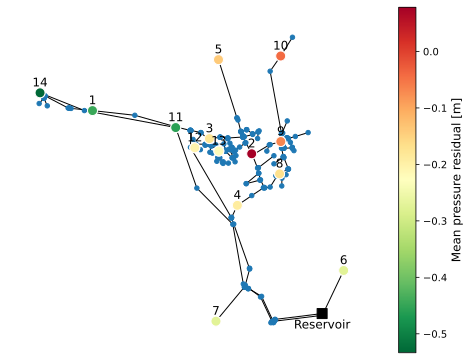

In [ ]:
# spatial residuals plot
mean_residuals_3a = ...
plot_network(...)

**Results discussion**:

<font color="red">Enter response here...

#### Part 3b: free valve coefficients + L1-norm regularisation
We assume that potential faults are unlikely to occur simultaneously and the vector $ \|C(\text{valves}) - \theta(\text{valves})\| $ is therefore expected to be **sparse**.

Ridge regression (L2-regularisation) shrinks parameter estimates (without actually driving them to 0) to reduce variance and improve prediction accuracy, while lasso regression (L1-regularisation) encourages sparsity, driving many parameter estimates exactly to zero.

Define regularisation term.

In [ ]:
valve_idx = link_df.index[link_df['link_type'] == 'valve'].tolist()
rho = 0 # adjust accordingly
def valve_reg_fun(theta):
    return rho * (1 / len(valve_idx)) * la.norm(..., ...) # define norm-1 or -2 regularisation term

Main SCP code.

In [18]:
# insert code here
# recall that cvxpy has its own functions (hint: la.norm needs to be replaced with cp.norm)

In [ ]:
C_3b = ...

# compute train mse
mse_train_3b = loss_fun(...)
mse_train_3b

Evaluate results on test dataset.

In [ ]:
# compute hydraulics
_, h_test = hydraulic_solver(...)

# compute test mse
mse_test_3b = loss_fun(...)
mse_test_3b

Text(0, 0.5, 'Pressure residual [m]')

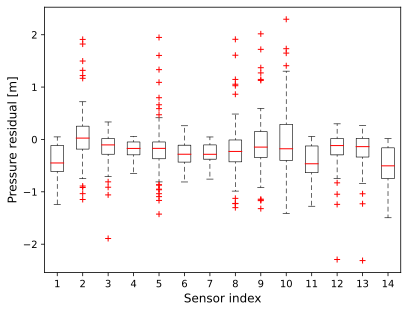

In [ ]:
# compute pressure residuals
residuals_3b = ...

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ...

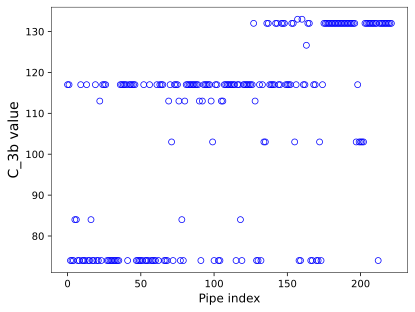

In [ ]:
# generate C_3b value scatter plot (pipes)

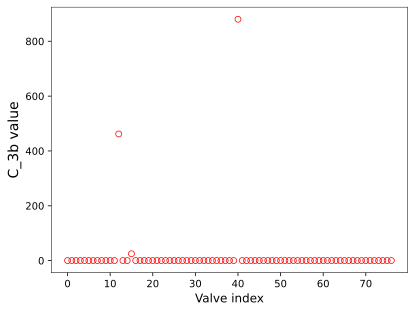

In [ ]:
# C_3b value scatter plot (valves)
valve_C = [...]
fig, ax = plt.subplots()
ax.scatter(...)

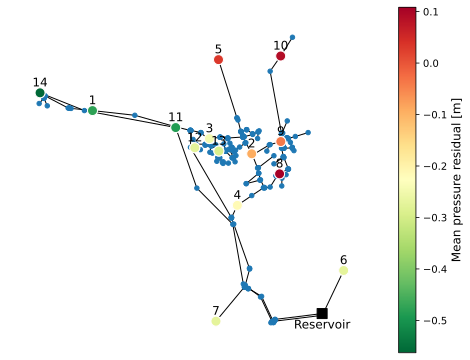

In [ ]:
# spatial residuals plot
mean_residuals_3b = ...
plot_network(...)

Plot faulty valve locations.

In [ ]:
# find indices of faulty valves and corresponding downstream nodes
valve_C = ...
valve_nodes = link_df.loc[valve_C, 'node_out'].tolist()

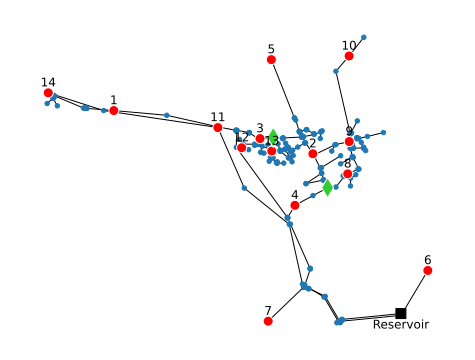

In [ ]:
plot_network(..., highlight_valves=...)

**Results discussion**:

<font color="red">Enter response here...